In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import least_squares
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from model.PDV import *
from model.data import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download data

In [2]:
load_from = pd.to_datetime('1995-01-01')  # Need at least 4 years prior to the first training day
train_start_date = pd.to_datetime('1995-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2022-05-15')

In [3]:
# # Load data on SPX and VIX
# spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
# vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)

In [4]:
# spx_data.to_csv('spx_data.csv')
# vix_data.to_csv('vix_data.csv')

In [5]:
spx_data = pd.read_csv('data/spx_data.csv', index_col=0, parse_dates=[0])
vix_data = pd.read_csv('data/vix_data.csv', index_col=0, parse_dates=[0])

In [6]:
data = create_df_from_yf(spx_data, train_start_date, test_start_date, vix_df=vix_data, log_return=True)
data

,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2018-12-24,-0.027487,7.555117e-04,0.3607
2018-12-26,0.048403,2.342868e-03,0.3041
2018-12-27,0.008526,7.269658e-05,0.2996
2018-12-28,-0.001242,1.543443e-06,0.2834


In [7]:
window = 1000
dataset = VIXDataset(data, window)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Fitting

## SGD

In [8]:
# params = torch.tensor([0.1, -1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5], requires_grad=True)
# optimizer = torch.optim.Adam([params], lr=0.01)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)

# for epoch in range(100):
#     losses = []
#     for x, y in dataloader:
#         preds = torch_predict(params, x)
#         loss = nn.MSELoss()(preds, y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.item())
#     epoch_loss = np.mean(losses)
#     print(f'Epoch {epoch} Loss {epoch_loss}')
#     scheduler.step(epoch_loss)

In [9]:
# print(params)
# evaluate(params.detach().numpy(), data, window)

## Least squares

In [10]:
lower_bound = [-np.inf, -np.inf, -np.inf, 0., 0., 0., 0., 0., 0.]
upper_bound = [np.inf, np.inf, np.inf, np.inf, np.inf, 1., np.inf, np.inf, 1.]
# initial_x = [0.1, -1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5]
initial_x = [0.054, -0.078, 0.82, 52.8, 3.79, 0.81, 17.3, 1.16, 0.43]
res = least_squares(residual, initial_x, args=(data, window), bounds=(lower_bound, upper_bound), verbose=2, ftol=1e-6)
res.x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3651e+00                                    2.35e+01    
       1              3         1.2768e+00      8.83e-02       2.11e+00       7.53e+00    
       2              4         1.2313e+00      4.55e-02       9.05e-01       1.82e-01    
       3              5         1.2244e+00      6.89e-03       4.99e+00       2.11e+00    
       4              6         1.2196e+00      4.79e-03       1.81e+00       1.91e-01    
       5              7         1.2173e+00      2.33e-03       4.87e+00       4.93e-01    
       6              8         1.2164e+00      9.38e-04       7.24e+00       3.71e-01    
       7              9         1.2159e+00      4.43e-04       7.24e+00       3.41e-01    
       8             10         1.2158e+00      1.27e-04       6.67e+00       1.89e-01    
       9             11         1.2158e+00      2.74e-05       6.55e-01       2.35e-03    

array([ 4.82545460e-02, -3.86411499e-02,  8.77448971e-01,  6.95118709e+01,
        1.63686383e+01,  8.18241621e-01,  1.42390736e+01,  1.65988273e+00,
        3.93864761e-01])

In [11]:
evaluate(res.x, data, window)

Mean: 0.0000, Min: -0.1149, Max: 0.1311, MAE: 0.0159, MSE: 0.0005, R^2: 0.9329


# Neural network to model log of ratio residuals (y/y_hat)


In [12]:
res_window = 60
hidden_size = 128
batch_size = 64

In [13]:
residuals, y_hat = residual(res.x, data, window, return_y_hat=True)
vix = residuals + y_hat
ratio_residuals = vix / y_hat
log_ratio_residuals = np.log(ratio_residuals)
log_ratio_residuals.shape

(5042,)

In [14]:
class ResidualNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(ResidualNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.window = input_size

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def predict(self, residuals: np.ndarray):
        r_sliding_window = torch.tensor(np.lib.stride_tricks.sliding_window_view(residuals, self.window), dtype=torch.float32)
        return self.forward(r_sliding_window)

class ResidualNNv2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_heads=4, num_layers=2, dropout=0.1):
        super(ResidualNNv2, self).__init__()
        self.window = input_size
        self.embedding = nn.Linear(1, hidden_size)
        self.pos_encoding = nn.Parameter(torch.randn(1, input_size, hidden_size))
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=hidden_size*4, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        x = x.unsqueeze(-1)  # Add feature dimension: (batch_size, seq_len, 1)
        x = self.embedding(x)  # (batch_size, seq_len, hidden_size)
        x = x + self.pos_encoding
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, hidden_size)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, hidden_size)
        x = self.fc_out(x[:, -1, :])  # Only use the last output: (batch_size, output_size)
        return x

    def predict(self, residuals: np.ndarray):
        r_sliding_window = torch.tensor(np.lib.stride_tricks.sliding_window_view(residuals, self.window), dtype=torch.float32)
        return self.forward(r_sliding_window)

# residual_nn = ResidualNN(input_size=res_window, hidden_size=hidden_size, output_size=1)
residual_nn = ResidualNNv2(input_size=res_window, hidden_size=hidden_size, output_size=1)
optimizer = torch.optim.Adam(residual_nn.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
residual_nn.to(device)
residual_nn

/home/luchungi/miniconda3/envs/signature/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


ResidualNNv2(
  (embedding): Linear(in_features=1, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

In [15]:
r_tensor = torch.tensor(log_ratio_residuals, dtype=torch.float32)
class ResidualDataset(Dataset):
    def __init__(self, residuals, window):
        self.residuals = residuals
        self.window = window
    def __len__(self):
        return len(self.residuals) - self.window
    def __getitem__(self, idx):
        return self.residuals[idx:idx+self.window], self.residuals[idx+self.window]
dataset = ResidualDataset(r_tensor, res_window)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataset) // batch_size

77

In [16]:
for epoch in range(500):
    losses = []
    current_lr = optimizer.param_groups[0]['lr']
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        preds = residual_nn(x).squeeze()
        loss = nn.MSELoss()(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    epoch_loss = np.mean(losses)
    print(f'Epoch {epoch} Loss {epoch_loss}')
    scheduler.step(epoch_loss)
    if scheduler.get_last_lr()[0] != current_lr:
        print(f'Learning rate changed from {current_lr} to {scheduler.get_last_lr()[0]}')
        current_lr = scheduler.get_last_lr()[0]

Epoch 0 Loss 0.573624670612984
Epoch 1 Loss 0.011633440858135238
Epoch 2 Loss 0.011161138417008214
Epoch 3 Loss 0.010610223944800405
Epoch 4 Loss 0.010066362706801066
Epoch 5 Loss 0.010252927746384954
Epoch 6 Loss 0.009913535424484273
Epoch 7 Loss 0.010215393918303724
Epoch 8 Loss 0.009955965286980454
Epoch 9 Loss 0.009882182276879366
Epoch 10 Loss 0.010128860570824681
Epoch 11 Loss 0.009661568048147436
Epoch 12 Loss 0.00978881506344829
Epoch 13 Loss 0.01008934586141736
Epoch 14 Loss 0.009826808445489941
Epoch 15 Loss 0.00998819787771656
Epoch 16 Loss 0.00996016153994088
Epoch 17 Loss 0.009882129149702497
Learning rate changed from 0.01 to 0.005
Epoch 18 Loss 0.009689844744757582
Epoch 19 Loss 0.009831503744069964
Epoch 20 Loss 0.009535525191145448
Epoch 21 Loss 0.009681355154428344
Epoch 22 Loss 0.009641220076726032
Epoch 23 Loss 0.009819953415829401
Epoch 24 Loss 0.009755535510917887
Epoch 25 Loss 0.00976560140052476
Epoch 26 Loss 0.009947761087320171
Learning rate changed from 0.005

KeyboardInterrupt: 

# Predicting out of sample

In [17]:
data = create_df_from_yf(spx_data, train_start_date, test_end_date, vix_df=vix_data, log_return=True)
data

,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2022-05-09,-0.032562,1.060253e-03,0.3475
2022-05-10,0.002455,6.026444e-06,0.3299
2022-05-11,-0.016600,2.755677e-04,0.3256
2022-05-12,-0.001297,1.681703e-06,0.3177


In [18]:
preds = predict(*res.x, data, window)
df_preds = data[window-1:].copy()
df_preds['preds'] = preds
df_preds['residuals'] = df_preds['vix'] - df_preds['preds']
df_preds['ratio'] = df_preds['vix'] / df_preds['preds']
df_preds['log_ratio'] = np.log(df_preds['ratio'])
df_preds

,r1,r2,vix,preds,residuals,ratio,log_ratio
1998-12-16,-0.000766,5.862656e-07,0.2996,0.231206,0.068394,1.295813,0.259138
1998-12-17,0.015407,2.373603e-04,0.2796,0.217894,0.061706,1.283191,0.249350
1998-12-18,0.006799,4.622674e-05,0.2504,0.211241,0.039159,1.185378,0.170062
1998-12-21,0.012389,1.534849e-04,0.2386,0.200698,0.037902,1.188852,0.172988
1998-12-22,0.000607,3.680809e-07,0.2278,0.200642,0.027158,1.135356,0.126947
...,...,...,...,...,...,...,...
2022-05-09,-0.032562,1.060253e-03,0.3475,0.344510,0.002990,1.008680,0.008642
2022-05-10,0.002455,6.026444e-06,0.3299,0.333054,-0.003154,0.990530,-0.009516
2022-05-11,-0.016600,2.755677e-04,0.3256,0.346002,-0.020402,0.941035,-0.060774
2022-05-12,-0.001297,1.681703e-06,0.3177,0.338091,-0.020391,0.939687,-0.062209


In [20]:
residual_nn.to('cpu')

# Create sliding window of log_ratio values
log_ratio_window = np.lib.stride_tricks.sliding_window_view(df_preds['log_ratio'].values, res_window)

# Convert to tensor
log_ratio_tensor = torch.tensor(log_ratio_window, dtype=torch.float32)

# Use residual_nn to predict
with torch.no_grad():
    nn_preds = residual_nn(log_ratio_tensor).squeeze().numpy()[:-1]

# Add predictions to df_preds with corresponding datetime index
df_preds.loc[df_preds.index[res_window:], 'nn_preds'] = np.exp(nn_preds)*df_preds.loc[df_preds.index[res_window:], 'preds']
df_preds['nn_residuals'] = df_preds['vix'] - df_preds['nn_preds']
df_preds


,r1,r2,vix,preds,residuals,ratio,log_ratio,nn_preds,nn_residuals
1998-12-16,-0.000766,5.862656e-07,0.2996,0.231206,0.068394,1.295813,0.259138,NaN,NaN
1998-12-17,0.015407,2.373603e-04,0.2796,0.217894,0.061706,1.283191,0.249350,NaN,NaN
1998-12-18,0.006799,4.622674e-05,0.2504,0.211241,0.039159,1.185378,0.170062,NaN,NaN
1998-12-21,0.012389,1.534849e-04,0.2386,0.200698,0.037902,1.188852,0.172988,NaN,NaN
1998-12-22,0.000607,3.680809e-07,0.2278,0.200642,0.027158,1.135356,0.126947,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-05-09,-0.032562,1.060253e-03,0.3475,0.344510,0.002990,1.008680,0.008642,0.342938,0.004562
2022-05-10,0.002455,6.026444e-06,0.3299,0.333054,-0.003154,0.990530,-0.009516,0.331966,-0.002066
2022-05-11,-0.016600,2.755677e-04,0.3256,0.346002,-0.020402,0.941035,-0.060774,0.344761,-0.019161
2022-05-12,-0.001297,1.681703e-06,0.3177,0.338091,-0.020391,0.939687,-0.062209,0.336271,-0.018571


<Axes: >

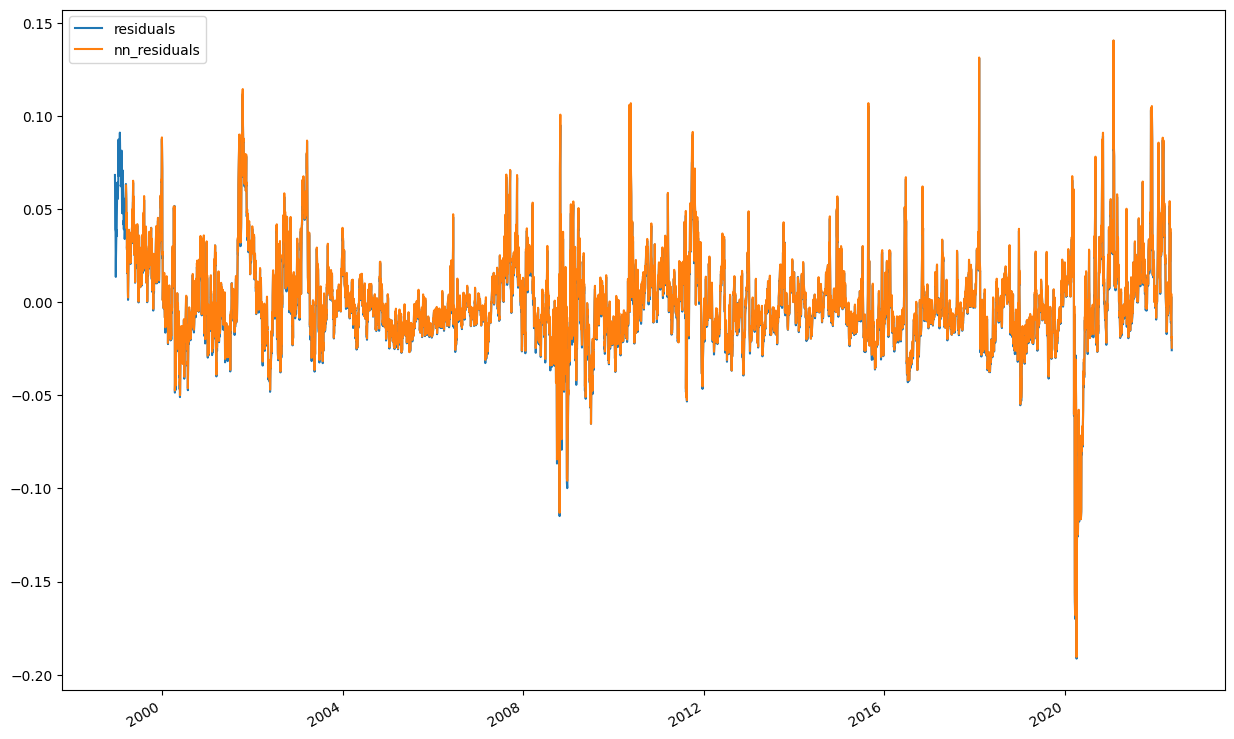

In [21]:
df_preds[['residuals', 'nn_residuals']].plot(figsize=(15, 10))